## Importing Required Modules

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# convenience function to plot graphs
# realated to given metric
def plot_graphs(history,metric):
  plt.plot(history.history[metric])
  plt.plot(history.history["val_"+metric])
  plt.xlabel("Epochs")
  plt.ylabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric,"val_"+metric])


In [3]:
dataset, info = tfds.load("imdb_reviews",with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete78HO98/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete78HO98/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete78HO98/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
# example first entry from dataset
for example,label in train_dataset.take(1):
  print("text: ",example.numpy())
  print("label: ",label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


## Preprocessing The Dataset

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
# first few entries from dataset along with their labels
for example, label in train_dataset.take(1):
  print("texts: ",example.numpy()[:3])
  print()
  print("labels: ",label.numpy()[:3])

texts:  [b"I really liked Tom Barman's AWTWB. You just have to let it come over you and enjoy it while it lasts, and don't expect anything. It's like sitting on a caf\xc3\xa9-terrace with a beer, in the summer sun, and watching the people go by. It definitely won't keep you pondering afterwards, that's true, but that's not a prerequisite for a good film. It's just the experience during the movie that's great.<br /><br />I felt there were a few strands that could have been worked out a little more, but being a Lynch fan I don't care that much anymore :)<br /><br />And I *loved* the style, or flair of this movie. It's slick, but fresh, and the soundtrack is a beauty. Any music-lover will get his kicks out of AWTWB, I can assure you.<br /><br />I'll give it 8 out 10.<br /><br />(music-wise 10 out of 10)"
 b"I just caught an episode about Brad, the crack cocaine addict who turned to a drug addicted life on the streets after his bicycle racing career went to shambles as fast as it started. 

In [7]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
# example of few review sentences after encoding
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  63, 405, ...,   0,   0,   0],
       [ 10,  41,   1, ...,   0,   0,   0],
       [ 11,   7,   2, ...,   0,   0,   0]])

## Defining model

In [60]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
    output_dim = 64,
    # masking is used to handle variable sequence lengths
    mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138369 (540.50 KB)
Trainable params: 138

## Training The Model

In [62]:
!pip install tensorflow-addons


In [63]:
import tensorflow as tf
import tensorflow_addons as tfa
# Modeli derleme
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.BinaryAccuracy(),
        tfa.metrics.F1Score(num_classes=1, average='macro', threshold=0.5)  # F1 skoru hesaplamak için
    ]
)

In [64]:
# training the model
history = model.fit(train_dataset,epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/5
391/391 [==============================] - 46s 97ms/step - loss: 0.8979 - mean_squared_error: 0.2980 - auc_12: 0.5493 - binary_accuracy: 0.5523 - f1_score: 0.4404 - val_loss: 0.6632 - val_mean_squared_error: 0.2351 - val_auc_12: 0.6592 - val_binary_accuracy: 0.6057 - val_f1_score: 0.6631
Epoch 2/5
391/391 [==============================] - 29s 74ms/step - loss: 0.6319 - mean_squared_error: 0.2196 - auc_12: 0.7421 - binary_accuracy: 0.6738 - f1_score: 0.6694 - val_loss: 0.5730 - val_mean_squared_error: 0.1951 - val_auc_12: 0.8640 - val_binary_accuracy: 0.6828 - val_f1_score: 0.5750
Epoch 3/5
391/391 [==============================] - 29s 73ms/step - loss: 0.5619 - mean_squared_error: 0.2058 - auc_12: 0.8189 - binary_accuracy: 0.7314 - f1_score: 0.6970 - val_loss: 0.4927 - val_mean_squared_error: 0.1610 - val_auc_12: 0.8835 - val_binary_accuracy: 0.7896 - val_f1_score: 0.8131
Epoch 4/5
391/391 [==============================] - 29s 73ms/step - loss: 0.4726 - mean_squared_error:

## Evaluating The Model

In [68]:
# evaluating the model

test_loss, test_mean_squared_error, test_auc, test_binary_accuracy, test_f1_score = model.evaluate(test_dataset)


391/391 [==============================] - 13s 33ms/step - loss: 0.4657 - mean_squared_error: 0.2310 - auc_12: 0.9103 - binary_accuracy: 0.8225 - f1_score: 0.8307


In [52]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'auc_10', 'binary_accuracy', 'f1_score', 'val_loss', 'val_mean_squared_error', 'val_auc_10', 'val_binary_accuracy', 'val_f1_score'])


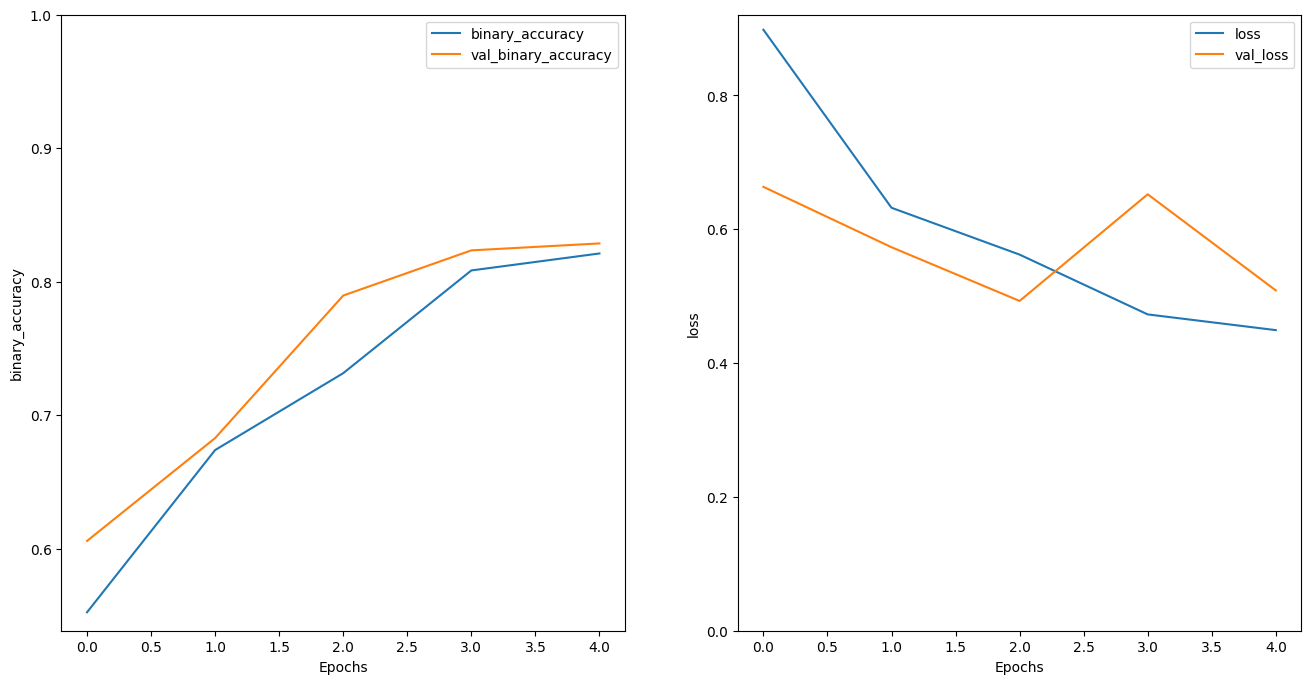

In [69]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "binary_accuracy")  # No need to change this
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")  # Correctly handled by the function now
plt.ylim(0,None)
plt.show()

## Making Prediction on New Sentence

In [70]:
sample_text = ("The movie was cool. The animation and the graphics"
               "were out of this world. I would recommend this movie.")


# if the prediction is >= 0.0, it is positive else it is negative
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 2s 2s/step


array([[0.5486113]], dtype=float32)

In [73]:
model.save('lstm_model_movie.keras', save_format='keras')


## Stacking LSTM Layers

In [74]:
from tensorflow.keras.models import load_model

model = load_model('lstm_model_movie.keras')

In [76]:
sample_text = ("The movie was cool. The animation and the graphics"
               "were out of this world. I would recommend this movie.")


# if the prediction is >= 0.0, it is positive else it is negative
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 0s 32ms/step


array([[0.5486113]], dtype=float32)

In [77]:
sample_text = ("The movie was not good. The animation and the graphics"
               "were terrible. I would not recommend this movie.")

predictions = model.predict(np.array([sample_text]))
predictions



1/1 [==============================] - 0s 22ms/step


array([[0.07496569]], dtype=float32)

In [78]:
sample_text =("This movie was terrible")

predictions = model.predict(np.array([sample_text]))
predictions



1/1 [==============================] - 0s 25ms/step


array([[0.00137187]], dtype=float32)